# Supervised GloVe

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import roc_curve, auc
import os, sys, time
from importlib import reload
%matplotlib inline

In [2]:
path = '/nfs/turbo/umms-awaljee/wsliu/Data/MIMIC/'

In [3]:
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [4]:
from keras.layers import Input, Embedding, Concatenate, Reshape, BatchNormalization, LSTM, CuDNNLSTM, CuDNNGRU, Lambda, Add
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.initializers import Constant
import keras.backend as K

module_path = '/home/wsliu/Codes/DLproj'
if module_path not in sys.path:
    sys.path.append(module_path)
if module_path+'/NRD' not in sys.path:
    sys.path.append(module_path+'/NRD')
from DL_utils import plot_roc
from keras_addon import AUCCheckPoint
from utils import get_frequency, preprocess

from ccs_tools import dx_multi, pr_multi, core_dtypes_pd, dx_label

Using TensorFlow backend.


In [5]:
from doublebatch import DoubleBatchGenerator

## Data Preparation

In [5]:
all_df = pd.read_csv(path+'MIMIC3_Updated_include.csv')

In [6]:
all_df = all_df.drop(columns=['PR'+str(j) for j in range(15, 40)])

In [7]:
n_DX = 30
n_PR = 15
DXs = ['DX'+str(n) for n in range(1, n_DX+1)]
PRs = ['PR'+str(n) for n in range(1, n_PR+1)]

In [11]:
all_df.columns

Index(['Unnamed: 0', 'HADM_ID', 'MORTALITY_1year', 'AGE', 'GENDER', 'LOS',
       'Eth', 'DX0', 'DX1', 'DX2', 'DX3', 'DX4', 'DX5', 'DX6', 'DX7', 'DX8',
       'DX9', 'DX10', 'DX11', 'DX12', 'DX13', 'DX14', 'DX15', 'DX16', 'DX17',
       'DX18', 'DX19', 'DX20', 'DX21', 'DX22', 'DX23', 'DX24', 'DX25', 'DX26',
       'DX27', 'DX28', 'DX29', 'PR0', 'PR1', 'PR2', 'PR3', 'PR4', 'PR5', 'PR6',
       'PR7', 'PR8', 'PR9', 'PR10', 'PR11', 'PR12', 'PR13', 'PR14'],
      dtype='object')

In [8]:
all_df.columns = ['Unnamed: 0', 'HADM_ID', 'MORTALITY_1year', 'AGE', 'GENDER', 'LOS', 'Eth'] + DXs + PRs

In [13]:
all_df.shape

(45348, 52)

In [9]:
DX_series = pd.Series()
for dx in DXs:
    DX_series = pd.concat([DX_series, all_df[dx]])

PR_series = pd.Series()
for pr in PRs:
    PR_series = pd.concat([PR_series, all_df[pr]])

In [10]:
DX_freq = DX_series.value_counts()
PR_freq = PR_series.value_counts()

In [11]:
DX_rarecutpoint = 21
PR_rarecutpoint = 21

In [12]:
DX_cat = sorted(DX_freq.loc[DX_freq>=DX_rarecutpoint].index)
PR_cat = sorted(PR_freq.loc[PR_freq>=PR_rarecutpoint].index)
DX_in = set(DX_cat)
PR_in = set(PR_cat)

code_cat = ['missing'] + DX_cat + PR_cat

In [13]:
len(DX_in), len(PR_in)

(1731, 558)

In [14]:
clean_df = all_df.copy()
for dx in DXs:
    clean_df.loc[~clean_df[dx].isin(DX_in), dx] = 'missing'
for pr in PRs:
    clean_df.loc[~clean_df[pr].isin(PR_in), pr] = 'missing'

In [15]:
clean_df = clean_df.loc[(clean_df[DXs] != 'missing').sum(axis=1)>0]
clean_df = clean_df.loc[(clean_df[PRs] != 'missing').sum(axis=1)>0]

In [16]:
len(all_df), len(clean_df)

(45348, 44997)

In [17]:
all_df = clean_df.reset_index(drop=True)

In [18]:
DX_dict = dict(zip(DX_cat, range(1, len(DX_cat)+1)))
PR_dict = dict(zip(PR_cat, range(len(DX_cat)+1, len(DX_cat)+len(PR_cat)+1)))

DX_dict['missing'] = 0
PR_dict['missing'] = 0

In [19]:
int_df = all_df.copy()
for dx in DXs:
    int_df[dx] = int_df[dx].map(DX_dict)
    
for pr in PRs:
    int_df[pr] = int_df[pr].map(PR_dict)

In [20]:
int_df.PR1.max(), len(code_cat)

(2289, 2290)

In [21]:
all_df = int_df.reset_index(drop=True)

In [22]:
kf = KFold(n_splits=5, shuffle=True, random_state=24)

train_idx, tst_idx = next(kf.split(all_df))

train_df0 = all_df.loc[train_idx].reset_index(drop=True)
tst_df = all_df.loc[tst_idx].reset_index(drop=True)

In [23]:
set(train_df0.HADM_ID).intersection(set(tst_df.HADM_ID)), len(train_df0), len(tst_df)

(set(), 35997, 9000)

### Collect Co-occurence Counts by Glove class

In [24]:
from glove import Glove

In [63]:
code_embed_dim=30
count_cap=20

In [64]:
g = Glove(input_dim=len(code_cat), embedding_dim=code_embed_dim, count_cap=count_cap)

In [27]:
g.update_cooccur(train_df0[DXs+PRs])

Updating co-occurrence matrix from a Dataframe with 35997 rows...
Finished. It takes 5.2 seconds to update the cooccurrences.


In [28]:
cooccur_df = g.get_cooccur_df()

In [65]:
g.train_glove(cooccur_df=cooccur_df, cache_path=model_path+'temp/', batch_size=1024, epochs=80, reducelr_patience=3)

Preparing data...
Defining the GloVe model...
Training the GloVe model...
Epoch 1/80
601355/601355 [==============================] - 4s 6us/step - loss: 0.7326
Epoch 2/80
601355/601355 [==============================] - 2s 3us/step - loss: 0.1546
Epoch 3/80
601355/601355 [==============================] - 2s 3us/step - loss: 0.1424
Epoch 4/80
601355/601355 [==============================] - 2s 3us/step - loss: 0.1340
Epoch 5/80
601355/601355 [==============================] - 2s 3us/step - loss: 0.1210
Epoch 6/80
601355/601355 [==============================] - 2s 3us/step - loss: 0.1055
Epoch 7/80
601355/601355 [==============================] - 2s 3us/step - loss: 0.0935
Epoch 8/80
601355/601355 [==============================] - 2s 3us/step - loss: 0.0842
Epoch 9/80
601355/601355 [==============================] - 2s 3us/step - loss: 0.0764
Epoch 10/80
601355/601355 [==============================] - 2s 3us/step - loss: 0.0700
Epoch 11/80
601355/601355 [============================

In [67]:
embed_mat = g.get_embed_mat()

In [44]:
cooccur_df.shape, train_df0.shape, len(cooccur_df)/len(train_df0)

((461914, 3), (35770, 52), 12.913447022644675)

### Data formating

In [29]:
train_df = train_df0.copy()

In [30]:
n_fold = 5

In [31]:
kf2 = KFold(n_splits=n_fold, random_state=23, shuffle=True)

In [32]:
trn_idx, val_idx = next(kf2.split(train_df))

In [33]:
trn_df = train_df.loc[trn_idx].reset_index(drop=True)
val_df = train_df.loc[val_idx].reset_index(drop=True)

### Data Generator

In [34]:
from keras.utils import Sequence

In [35]:
readm_batchsize = 256
batchsize_ratio = 12

In [36]:
class DoubleBatchGenerator(Sequence):
    'Generates data from two datasets'
    def __init__(self, cooccur_df, readm_df, readm_batchsize=512, batchsize_ratio=16, shuffle=True, scaling_factor=0.75, 
                count_cap=20):
        '''Initialization
        Here coocur_df and readm_df need to have integer index from 0, i.e. they need to reset_index()'''
        self.readm_batchsize = readm_batchsize
        self.cooccur_batchsize = readm_batchsize*batchsize_ratio
        self.batchsize_ratio = batchsize_ratio
        self.cooccur_df = cooccur_df
        self.readm_df = readm_df
        self.shuffle = shuffle
        self.__scaling_factor = scaling_factor
        self.__count_cap = count_cap
        self.batch_size = self.readm_batchsize
        self.n = self.__len__()*self.batch_size
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        readm_steps = np.floor(len(self.readm_df) / self.readm_batchsize)
        cooccur_steps = np.floor(len(self.cooccur_df)/self.cooccur_batchsize)
        return int(np.min((readm_steps, cooccur_steps)))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        readm_indexes = self.readm_indexes[index*self.readm_batchsize:(index+1)*self.readm_batchsize]
        cooccur_indexes = self.cooccur_indexes[index*self.cooccur_batchsize:(index+1)*self.cooccur_batchsize]

        DX_mat = self.readm_df.loc[readm_indexes, DXs].values
        PR_mat = self.readm_df.loc[readm_indexes, PRs].values
        continue_mat = self.readm_df.loc[readm_indexes, ['AGE', 'GENDER', 'LOS']].values
        eth_array = self.readm_df.loc[readm_indexes, 'Eth'].values
        eth_mat = to_categorical(eth_array, num_classes=5)
        other_mat = np.concatenate((continue_mat, eth_mat), axis=1)
        y_readm = self.readm_df.loc[readm_indexes, 'MORTALITY_1year'].astype(int).values
        Y_readm = to_categorical(y_readm, num_classes=2)

        focal_id = self.cooccur_df.loc[cooccur_indexes, 'focal_index'].values
        context_id = self.cooccur_df.loc[cooccur_indexes, 'context_index'].values
        y_cooccur = np.log(self.cooccur_df.loc[cooccur_indexes, 'cooccur_counts'].values)
        
        focal_id = np.reshape(focal_id, (self.readm_batchsize, self.batchsize_ratio))
        context_id = np.reshape(context_id, (self.readm_batchsize, self.batchsize_ratio))
        y_cooccur = np.reshape(y_cooccur, (self.readm_batchsize, self.batchsize_ratio))

        return [DX_mat, PR_mat, other_mat, focal_id, context_id], [Y_readm, y_cooccur]

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.readm_indexes = np.arange(len(self.readm_df))
        self.cooccur_indexes = np.arange(len(self.cooccur_df))
        if self.shuffle == True:
            np.random.shuffle(self.readm_indexes)
            np.random.shuffle(self.cooccur_indexes)

In [ ]:
trn_gen = DoubleBatchGenerator(cooccur_df=cooccur_df, readm_df=trn_df, readm_batchsize=readm_batchsize, 
                               batchsize_ratio=batchsize_ratio, shuffle=True)

In [39]:
val_gen = DoubleBatchGenerator(cooccur_df=cooccur_df, readm_df=val_df, readm_batchsize=len(val_df), 
                               batchsize_ratio=batchsize_ratio, shuffle=False)

tst_gen = DoubleBatchGenerator(cooccur_df=cooccur_df, readm_df=tst_df, readm_batchsize=len(tst_df), 
                               batchsize_ratio=batchsize_ratio, shuffle=False)

In [50]:
val_x, val_y = next(iter(val_gen))

In [51]:
len(trn_df)/readm_batchsize, len(val_df)/readm_batchsize, len(cooccur_df)/readm_batchsize/batchsize_ratio

(112.48828125, 28.125, 195.75358072916666)

### Model Building

In [52]:
from setsum_layer import SetSum, MaskedSum, MaskedDense, MaskedPooling
from keras.layers import Multiply

In [30]:
from keras_multi_head import MultiHeadAttention

In [53]:
code_embed_dim = 30
md_width = 8
fc_width = 512
dropout = 0.3
job_index = 0
parent_pairs = None

In [68]:
embed_initializer = Constant(embed_mat)

In [54]:
embed_initializer = 'uniform'

In [123]:
input_w = Input(shape=(batchsize_ratio,), name='focal_index')
input_v = Input(shape=(batchsize_ratio,), name='context_index')
if parent_pairs is None:
    embed_layer = Embedding(input_dim=len(code_cat), output_dim=code_embed_dim, name='embed', 
                            embeddings_initializer=embed_initializer)
else:
    embed_layer = Embedding(input_dim=len(code_cat), output_dim=code_embed_dim, name='embed',
                            embeddings_regularizer=Parent_reg(parent_pairs, lamb, metric))
w_embed = embed_layer(input_w)
v_embed = embed_layer(input_v)
bias_layer = Embedding(input_dim=len(code_cat), output_dim=1, name='bias')
w_bias = bias_layer(input_w)
v_bias = bias_layer(input_v)

inner = Multiply()([w_embed, v_embed])
inner = Lambda(lambda x: K.sum(x, axis=-1, keepdims=True))(inner)

merged = Concatenate(axis=-1)([inner, w_bias, v_bias])

output_cooccur = Lambda(lambda x: K.sum(x, axis=-1, keepdims=False), name='cooccur')(merged)

input_DX = Input(shape = (len(DXs),))
DX_embed = embed_layer(input_DX)
DX_embed = MaskedDense(md_width, activation='relu')(DX_embed)
DX_embed = MaskedSum()(DX_embed)
input_PR = Input(shape = (len(PRs),))
PR_embed = embed_layer(input_PR)
PR_embed = MaskedDense(md_width, activation='relu')(PR_embed)
PR_embed = MaskedSum()(PR_embed)
input_other = Input(shape=(8, ))
merged = Concatenate(axis=1)([DX_embed, PR_embed, input_other])
merged = Dense(fc_width, activation='relu')(merged)
merged = Dropout(dropout)(merged)
output_readm = Dense(2, activation='softmax', name='readm')(merged)

model = Model(inputs=[input_DX, input_PR, input_other, input_w, input_v], 
              outputs=[output_readm, output_cooccur])

In [56]:
count_cap = 20
scaling_factor = 0.75
def weighting_factor(count):
    ge_mask = K.cast(K.greater_equal(count, count_cap), K.floatx())
    l_mask = K.cast(K.less(count, count_cap), K.floatx())
    return 1.*ge_mask + np.power(count/count_cap, scaling_factor)*l_mask

def loss_cooccur(y_true, y_pred):
    weight_cooccur = weighting_factor(K.exp(y_true))
    return K.mean(K.square(y_pred - y_true)*weight_cooccur)

In [124]:
adam = Adam(lr=5e-4)
model.compile(loss={'readm':'categorical_crossentropy', 'cooccur':loss_cooccur}, 
             optimizer=adam, 
             loss_weights={'readm':1., 'cooccur':10.})

In [125]:
auccheckpoint = AUCCheckPoint(filepath=model_path+'embeding_nn_temp'+str(job_index)+'.h5', validation_x=val_x, validation_y=val_y,
                              auc_output_idx=[0])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=K.epsilon())
#earlystop = EarlyStopping(monitor='val_loss', patience=20)

In [115]:
class_weight = {'readm':{0:1., 1:5.}}

In [126]:
hist = model.fit_generator(generator=trn_gen, validation_data=val_gen, epochs=50, verbose=1, 
                           callbacks=[auccheckpoint, reduce_lr], class_weight=class_weight)

Epoch 1/50
112/112 [==============================] - 3s 27ms/step - loss: 3.5448 - readm_loss: 2.0399 - cooccur_loss: 0.1505 - val_loss: 1.8079 - val_readm_loss: 0.5699 - val_cooccur_loss: 0.1238
AUC_readm: 0.7946
Mean AUC: 0.7946

Epoch 2/50
112/112 [==============================] - 2s 14ms/step - loss: 2.4054 - readm_loss: 1.3405 - cooccur_loss: 0.1065 - val_loss: 1.6089 - val_readm_loss: 0.6760 - val_cooccur_loss: 0.0933
AUC_readm: 0.8209
Mean AUC: 0.8209

Epoch 3/50
112/112 [==============================] - 2s 14ms/step - loss: 1.8602 - readm_loss: 1.0197 - cooccur_loss: 0.0840 - val_loss: 1.2076 - val_readm_loss: 0.4404 - val_cooccur_loss: 0.0767
AUC_readm: 0.8329
Mean AUC: 0.8329

Epoch 4/50
112/112 [==============================] - 2s 14ms/step - loss: 1.5958 - readm_loss: 0.8867 - cooccur_loss: 0.0709 - val_loss: 1.1901 - val_readm_loss: 0.5200 - val_cooccur_loss: 0.0670
AUC_readm: 0.8441
Mean AUC: 0.8441

Epoch 5/50
112/112 [==============================] - 2s 14ms/step -

112/112 [==============================] - 2s 14ms/step - loss: 1.0180 - readm_loss: 0.6065 - cooccur_loss: 0.0412 - val_loss: 0.8122 - val_readm_loss: 0.3967 - val_cooccur_loss: 0.0416
AUC_readm: 0.8702
Mean AUC: 0.8702

Epoch 37/50
112/112 [==============================] - 2s 14ms/step - loss: 1.0182 - readm_loss: 0.6039 - cooccur_loss: 0.0414 - val_loss: 0.7906 - val_readm_loss: 0.3754 - val_cooccur_loss: 0.0415
AUC_readm: 0.8703
Mean AUC: 0.8703

Epoch 38/50
112/112 [==============================] - 2s 14ms/step - loss: 1.0204 - readm_loss: 0.6072 - cooccur_loss: 0.0413 - val_loss: 0.8233 - val_readm_loss: 0.4084 - val_cooccur_loss: 0.0415
AUC_readm: 0.8692
Mean AUC: 0.8692

Epoch 39/50
112/112 [==============================] - 2s 14ms/step - loss: 1.0151 - readm_loss: 0.6053 - cooccur_loss: 0.0410 - val_loss: 0.8093 - val_readm_loss: 0.3947 - val_cooccur_loss: 0.0415
AUC_readm: 0.8696
Mean AUC: 0.8696

Epoch 40/50
112/112 [==============================] - 2s 14ms/step - loss: 

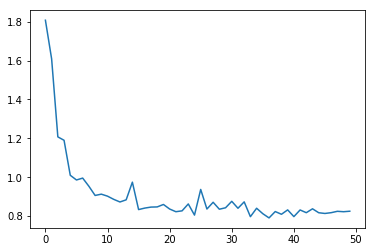

In [127]:
plt.plot(hist.history['val_loss'])

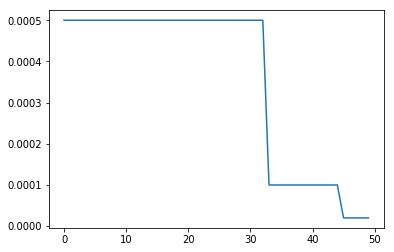

In [128]:
plt.plot(hist.history['lr'])

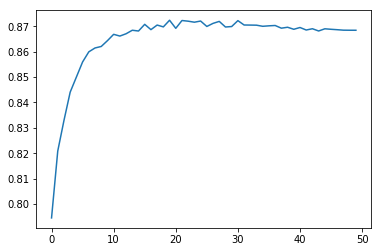

In [129]:
plt.plot(auccheckpoint.auc_history['readm'])

In [130]:
model.load_weights(model_path+'embeding_nn_temp'+str(job_index)+'.h5')

In [131]:
y = model.predict_generator(tst_gen, verbose=1)

y_pred = y[0][:, 1]
y_true = tst_df.MORTALITY_1year.astype(int).values

1/1 [==============================] - 0s 89ms/step


{0: 0.8751385225171326}

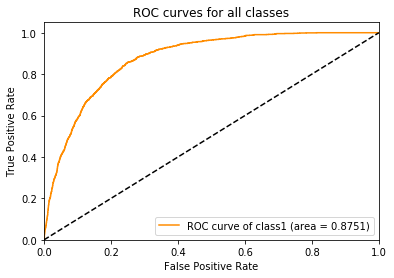

In [132]:
plot_roc(y_pred, y_true)